In [1]:
# !pip install pythainlp
# !pip install stop_words

In [1]:
import pythainlp
from pythainlp import word_tokenize
from pythainlp.corpus import wordnet
from pythainlp.corpus import thai_stopwords

import nltk
from nltk.stem.porter import PorterStemmer
from nltk.corpus import words

from stop_words import get_stop_words

import pandas as pd

In [2]:
nltk.download('words')
th_stop = tuple(thai_stopwords())
en_stop = tuple(get_stop_words('en'))
p_stemmer = PorterStemmer()

[nltk_data] Downloading package words to /Users/nat/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [3]:
import re
import string

def clean_msg(msg):
    # ลบ text ที่อยู่ในวงเล็บ <> ทั้งหมด
    msg = re.sub(r'<.*?>','', msg)
    
    # ลบ hashtag
    msg = re.sub(r'#','',msg)
    msg = msg.replace('ชิมช็อปใช้เฟส', '')    
    
    msg = msg.replace('ลทบ', 'ลงทะเบียน')    
    
    # ลบ เครื่องหมายคำพูด (punctuation)
    for c in string.punctuation:
        msg = re.sub(r'\{}'.format(c),'',msg)
    
    # ลบ separator เช่น \n \t
    msg = ' '.join(msg.split())
    
    return msg

In [4]:
def split_word(text):
    tokens = word_tokenize(text,engine='newmm')
    
    # Remove stop words ภาษาไทย และภาษาอังกฤษ
    tokens = [i for i in tokens if not i in th_stop and not i in en_stop]
    
    # หารากศัพท์ภาษาไทย และภาษาอังกฤษ
    # English
    tokens = [p_stemmer.stem(i) for i in tokens]
    
    # Thai
    tokens_temp=[]
    for i in tokens:
        w_syn = wordnet.synsets(i)
        if (len(w_syn)>0) and (len(w_syn[0].lemma_names('tha'))>0):
            tokens_temp.append(w_syn[0].lemma_names('tha')[0])
        else:
            tokens_temp.append(i)
    
    tokens = tokens_temp
    
    # ลบตัวเลข
    tokens = [i for i in tokens if not i.isnumeric()]
    
    # ลบช่องว่าง
    tokens = [i for i in tokens if not ' ' in i]

    return tokens

In [5]:
split_word("สวัสดีจ้าแมวสุนัขหมา")

['สวัสดี', 'แมว', 'สุนัข', 'หมา']

In [6]:
!pwd

/Users/nat/0000_DataScienceJupyter/000A/notebooks/hw-nlp


In [7]:
tweets = pd.read_csv('shop.csv',encoding="utf8", header=None)

In [8]:
tweets.describe()

,0
count,1228
unique,1226
top,รับลงค่ะ #ชิมช็อปใช้เฟส2
freq,2


In [9]:
tweets.head()

,0
0,ตื่นตี5:30มันวันหยุดกูกูกดเข้าระบบตั้งแต่5:55แ...
1,#ชิมช็อปใช้เฟส2 มึงมาประกาศรับลงทะเบียนให้ แล...
2,เข้าได้รอบเดียว คือทำได้ต่อยาว เช้านี้10คน หมด...
3,เต็มแล้วจ้าาา ตื่นมาทำไรตั้งแต่ตี 5 😂😂 #ชิมช็อ...
4,เก็บเงินค่าซื้อหวยแต่ละเดือนได้มากกว่าชิมช้อปใ...


In [10]:
# t=tweets[0]
data = []
clean_text = [clean_msg(str(txt)) for txt in tweets[0]]
for tweet in clean_text:
    data.append(split_word(str(tweet)))
tokens_list = data

In [11]:
# clean_text

In [12]:
print(tokens_list[1])
# print(tweets.loc[0][0])

['ประกาศรับ', 'ลงทะเบียน', 'คนอื่น', 'ไม่ได้', 'ลูก', 'ดี', 'กาล', 'วิ่ง', 'นิ', 'นั่ง', 'ไถ', 'โทร', 'แล้วก็', 'ออกจาก', 'หน้า', 'เวป', 'ดิ']


In [13]:
# BOW

In [14]:
from sklearn.feature_extraction.text import CountVectorizer

tokens_list_j = [','.join(tkn) for tkn in tokens_list]
cvec = CountVectorizer(analyzer=lambda x:x.split(','))
c_feat = cvec.fit_transform(tokens_list_j)

# c_feat
# cvec.vocabulary_
# tokens_list_j

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
tvec = TfidfVectorizer(analyzer=lambda x:x.split(','),)
t_feat = tvec.fit_transform(tokens_list_j)

# t_feat.toarray()
# tvec.get_feature_names()
# t_feat[:,:5].todense()
# len(tvec.idf_)

In [16]:
#!pip install gensim

In [17]:
from gensim.models import Word2Vec

In [18]:
model = Word2Vec(tokens_list, min_count=1)
sim_words=model.wv.similar_by_word('แม่')
print(sim_words)

[('คน', 0.9867021441459656), ('ไม่ได้', 0.9864341020584106), ('กด', 0.9845086336135864), ('ทำ', 0.9819343686103821), ('คิว', 0.9804556369781494), ('\u200b', 0.9803707003593445), ('อี', 0.9796478748321533), ('อิ', 0.9782682657241821), ('คนอื่น', 0.9778757095336914), ('อย่า', 0.9776197075843811)]


In [19]:
from sklearn.cluster import KMeans

n_clusters = 4

kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(t_feat)


In [20]:
pd.DataFrame(pred_y).describe()

,0
count,1228.000000
mean,0.375407
std,0.819454
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,3.000000


In [21]:
# summary = {}
# for idx,tweet in enumerate(tokens_list):
#     predicted_val = pred_y[idx]
#     if predicted_val not in summary.keys():
#         summary[predicted_val] = []
#     summary[predicted_val] += [tweet]
    
# #     print("CLASS={} TWEET={}".format(predicted_val, ','.join(tweet)))

In [22]:
# summar

In [23]:
len(g1)

NameError: name 'g1' is not defined

In [103]:
tweets.head()

,0
0,ตื่นตี5:30มันวันหยุดกูกูกดเข้าระบบตั้งแต่5:55แ...
1,#ชิมช็อปใช้เฟส2 มึงมาประกาศรับลงทะเบียนให้ แล...
2,เข้าได้รอบเดียว คือทำได้ต่อยาว เช้านี้10คน หมด...
3,เต็มแล้วจ้าาา ตื่นมาทำไรตั้งแต่ตี 5 😂😂 #ชิมช็อ...
4,เก็บเงินค่าซื้อหวยแต่ละเดือนได้มากกว่าชิมช้อปใ...


In [134]:
clusters_text = [ pd.DataFrame(tweets[pred_y == c]) for c in range(n_clusters)]

In [142]:
# q = clusters

In [137]:
# for i in range(n_clusters):
#     print("class={}".format(i))
#     print("--------------")    
#     g[i] = (tweets[pred_y == i])
#     print("--------------")

In [139]:
# x = pd.DataFrame(g)

In [141]:
# g[1]

In [145]:
# q[1]

In [146]:
# from __future__ import print_function
# import collections
# import math
# import numpy as np
# import os
# import random
# import tensorflow as tf
# import zipfile
# from matplotlib import pylab
# from six.moves import range
# from six.moves.urllib.request import urlretrieve
# from sklearn.manifold import TSNE

In [147]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

# words = [reverse_dictionary[i] for i in range(1, num_points+1)]
# plot(two_d_embeddings, words)

In [44]:
def clustering_on_wordvecs(word_vectors, num_clusters):
    # Initalize a k-means object and use it to extract centroids
    kmeans_clustering = KMeans(n_clusters = num_clusters, init='k-means++');
    idx = kmeans_clustering.fit_predict(word_vectors);
    
    return kmeans_clustering.cluster_centers_, idx;

In [150]:
Z = model.wv.vectors

In [151]:
# centers, clusters = clustering_on_wordvecs(Z, 20);

In [152]:
# centers, clusters = clustering_on_wordvecs(Z, 4);

In [153]:
# pd.DataFrame(clusters).describe()

In [154]:
# labels = model.wv.index2word

In [155]:
pred_y

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [40]:
import matplotlib.pyplot as plt # วาดรูป
from pythainlp.tokenize import word_tokenize # ตัดคำไทย
from wordcloud import WordCloud # สร้าง Wordcloud

In [58]:
yyyy = pd.DataFrame(tokens_list)

cls = []
cls.append(yyyy[pred_y == 0])
cls.append(yyyy[pred_y == 1])
cls.append(yyyy[pred_y == 2])
cls.append(yyyy[pred_y == 3])

cls[1].iloc[: 1]


,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
7,ระบบ,ขี้โกง,พวกเรา,รอ,คิว,คน,ลงทะเบียน,ไม่ต้อง,รอ,คิว,...,None,None,None,None,None,None,None,None,None,None


In [99]:
# cls[1].iloc[: 1].dropna(axis=1).values

# cls[1].head()
(cls[1].head())


,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
7,ระบบ,ขี้โกง,พวกเรา,รอ,คิว,คน,ลงทะเบียน,ไม่ต้อง,รอ,คิว,...,None,None,None,None,None,None,None,None,None,None
24,แม่,รอ,งง,งง,เห้ยยคน,ตัง,คน,เฒ่า,คนแก่,อยาก,...,None,None,None,None,None,None,None,None,None,None
32,หน้า,รอ,คิว,แนะนำ,วิธี,😂,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
66,ไม่ได้,หรอก,อี,คน,ระบบ,อะ,เข้าไป,กด,คน,ไม่ได้,...,None,None,None,None,None,None,None,None,None,None
67,แบงค์,ป่ะ,บอ,รอ,กี่,คิว,รอ,เคว้งคว้าง,าาาาา,None,...,None,None,None,None,None,None,None,None,None,None


In [127]:
flatten = lambda l: [item for sublist in l for item in sublist]

l_cls0 = [x.dropna().values for i,x in cls[0].iterrows()]
l_cls1 = [x.dropna().values for i,x in cls[1].iterrows()]
l_cls2 = [x.dropna().values for i,x in cls[2].iterrows()]
l_cls3 = [x.dropna().values for i,x in cls[3].iterrows()]

# print(flatten(l_cls0))

In [128]:
# flatten = lambda l: [item for sublist in l for item in sublist]
# xyz = []
# for i,x in cls[0].head().iterrows():
# #     print(x.dropna().values)
# #     xyz = xyz + x.dropna().values
# #     print(">", x.dropna().values)
#     xyz.append(x.dropna().values)

# print(flatten(xyz))

In [129]:
# xyz

In [130]:
tweets.head()

,0
0,ตื่นตี5:30มันวันหยุดกูกูกดเข้าระบบตั้งแต่5:55แ...
1,#ชิมช็อปใช้เฟส2 มึงมาประกาศรับลงทะเบียนให้ แล...
2,เข้าได้รอบเดียว คือทำได้ต่อยาว เช้านี้10คน หมด...
3,เต็มแล้วจ้าาา ตื่นมาทำไรตั้งแต่ตี 5 😂😂 #ชิมช็อ...
4,เก็บเงินค่าซื้อหวยแต่ละเดือนได้มากกว่าชิมช้อปใ...


In [131]:
# tweets.iloc[:1].values

In [132]:
# flatten = lambda l: [item for sublist in l for item in sublist]
# cls = {}

# for i in range(n_clusters):
#     s = q.loc[i]
#     cls[i] = []
#     for item in s:
#         if item is not None:
#             cls[i] += item

In [133]:
# tokens_list[pred_y == 0]

In [134]:
# # yyyy[pred_y == 1]
# for i in range(n_clusters):
#     s = q.loc[i]
#     cls[i] = []
#     for item in s:
#         if item is not None:
#             cls[i] += item

In [136]:
def wordCloud(lst):
    wordcloud = WordCloud(font_path='THSarabunNew.ttf',
         background_color="white",
                      width=1600, # กว้าง
                      	height=900, # ยาว
                      	collocations=False,
                      regexp=r"[\u0E00-\u0E7Fa-zA-Z']+"
                      ).generate(' '.join(lst))
    plt.imshow(wordcloud, cmap=plt.cm.gray, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [149]:
# flatten(l_cls0)

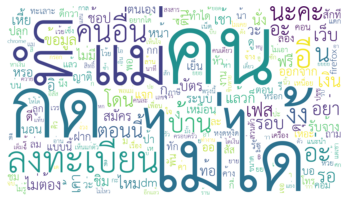

In [142]:
wordCloud(flatten(l_cls0))


In [138]:
# cls[0]

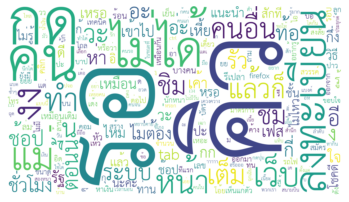

In [143]:
# class 2 รอ
wordCloud(flatten(l_cls1))

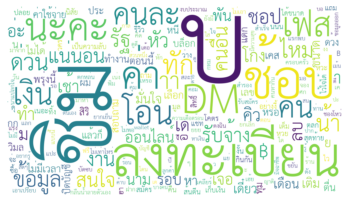

In [148]:
#class 3 ลงทะเบียน
wordCloud(flatten(l_cls2))

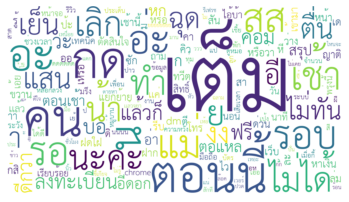

In [146]:
#class 4 เต็ม
wordCloud(flatten(l_cls3))